In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

In [6]:

import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

# Configuración para visualizaciones
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
%matplotlib inline

# Crear diccionario para almacenar los dataframes
prediction_dfs = {}

# Listar las criptomonedas a cargar
coins = ['bitcoin', 'ethereum', 'cardano']

# Cargar los datos guardados previamente
for coin in coins:
    file_path = f"../data/{coin}_prediction_data.csv"
    
    if os.path.exists(file_path):
        # Cargar CSV
        df = pd.read_csv(file_path)
        
        # Convertir la columna de fecha a datetime 
        df['fetch_date'] = pd.to_datetime(df['fetch_date'])
            
        # Almacenar en el diccionario
        prediction_dfs[coin] = df
        print(f"Datos de {coin} cargados: {df.shape[0]} filas y {df.shape[1]} columnas")
    else:
        print(f"Advertencia: No se encontró el archivo {file_path}")



Datos de bitcoin cargados: 234 filas y 33 columnas
Datos de ethereum cargados: 237 filas y 33 columnas
Datos de cardano cargados: 244 filas y 33 columnas


In [8]:
# Función para evaluar el rendimiento de un modelo
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {
        'model': model_name,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

# Función para entrenar múltiples modelos y compararlos
def train_and_compare_models(X_train, X_test, y_train, y_test):
    # Definir modelos para comparar
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'Lasso': Lasso(alpha=0.1),
        'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }
    
    results = []
    predictions = {}
    
    for name, model in models.items():
        # Crear un pipeline con escalado de características
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
        
        # Entrenar el modelo
        pipeline.fit(X_train, y_train)
        
        # Realizar predicciones
        y_pred = pipeline.predict(X_test)
        predictions[name] = y_pred
        
        # Evaluar el modelo
        result = evaluate_model(y_test, y_pred, name)
        results.append(result)
    
    # Convertir resultados a DataFrame
    results_df = pd.DataFrame(results)
    return results_df, predictions



Procesando BITCOIN


c:\Users\corebi\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.009e+08, tolerance: 3.751e+06
  model = cd_fast.enet_coordinate_descent(



El mejor modelo para bitcoin es: Ridge

Resultados de los modelos:
            model        rmse         mae       r2
            Ridge 2105.356919 1467.427465 0.919650
            Lasso 2131.165274 1511.399399 0.917668
       ElasticNet 2141.973078 1475.952326 0.916831
Linear Regression 2170.528837 1536.953882 0.914599
    Random Forest 2347.328543 1853.153921 0.900119
Gradient Boosting 2573.780731 1947.980157 0.879918


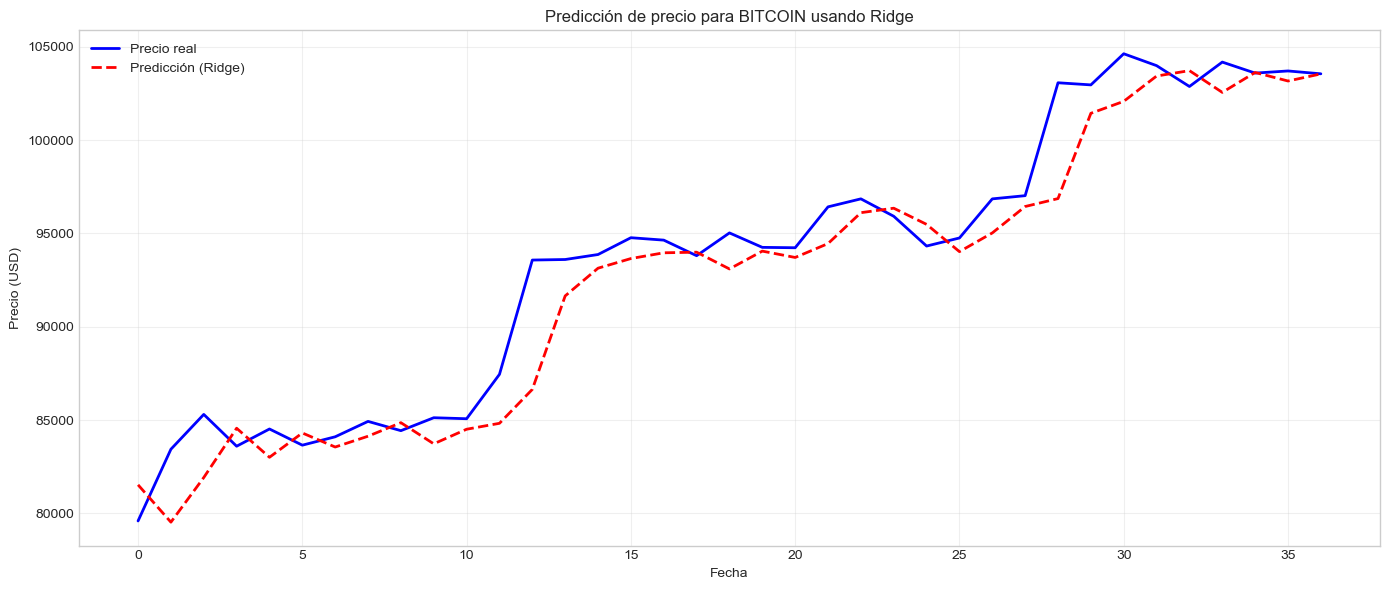


Procesando ETHEREUM

El mejor modelo para ethereum es: ElasticNet

Resultados de los modelos:
            model       rmse        mae       r2
       ElasticNet 107.036722  67.805051 0.894485
            Ridge 117.979208  74.727141 0.871808
            Lasso 129.082511  85.552168 0.846544
Linear Regression 140.259450  94.439984 0.818818
    Random Forest 193.688230 154.227085 0.654493
Gradient Boosting 195.756220 144.346618 0.647076


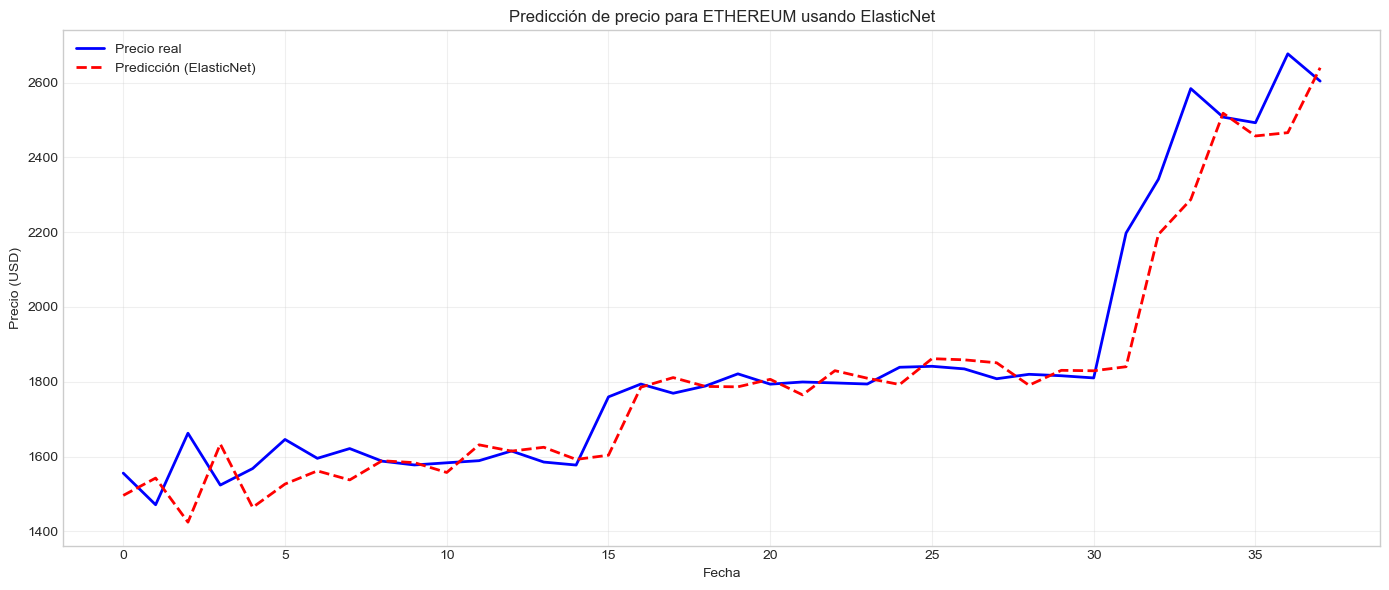


Procesando CARDANO

El mejor modelo para cardano es: Linear Regression

Resultados de los modelos:
            model     rmse      mae        r2
Linear Regression 0.031580 0.021291  0.803420
            Ridge 0.031831 0.021416  0.800285
       ElasticNet 0.034073 0.026556  0.771160
            Lasso 0.041493 0.033127  0.660632
    Random Forest 0.091107 0.071484 -0.636168
Gradient Boosting 0.093213 0.073224 -0.712664


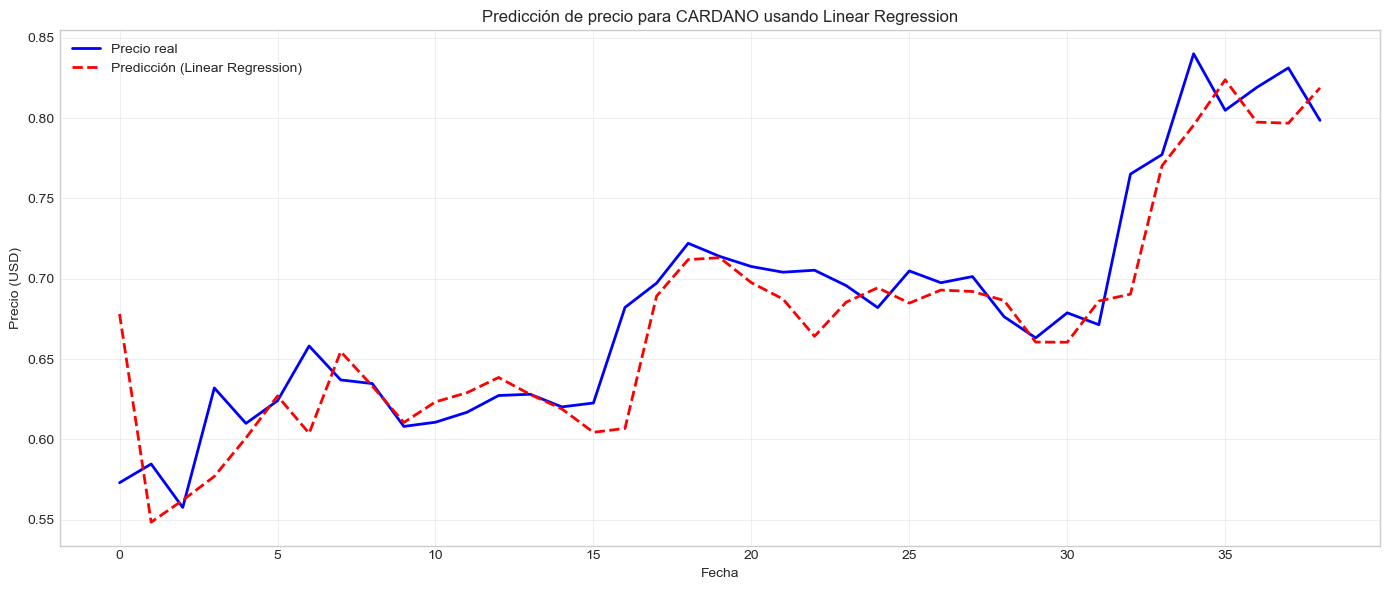

In [9]:
# Procesar cada criptomoneda
results_by_coin = {}
best_models = {}
feature_importance = {}

for coin in prediction_dfs.keys():
    print(f"\n{'='*50}")
    print(f"Procesando {coin.upper()}")
    print(f"{'='*50}")
    
    # Obtener datos
    df = prediction_dfs[coin].copy()
    
    # Asegurarse de que los datos estén ordenados por fecha
    if 'date' in df.columns:
        df = df.sort_values('date')
    
    # Seleccionar solo características numéricas
    numeric_cols = df.select_dtypes(include=['number']).columns
    df_numeric = df[numeric_cols]
    
    # Verificar si tenemos la variable objetivo
    if 'next_day_price' not in numeric_cols:
        print(f"Error: 'next_day_price' no es una columna numérica en el dataframe de {coin}.")
        continue
    
    # Eliminar filas con NaN
    df_numeric = df_numeric.dropna()
    
    # Eliminar los primeros 7 días que no tienen suficiente historia
    if len(df_numeric) > 7:
        df_numeric = df_numeric.iloc[7:]
    else:
        print(f"Advertencia: No hay suficientes datos para {coin} después de eliminar los primeros 7 días.")
        continue
    
    # Separar características y variable objetivo
    X = df_numeric.drop('next_day_price', axis=1)
    y = df_numeric['next_day_price']
    
    # Dividir en conjuntos de entrenamiento y prueba (80% train, 20% test)
    # Usar TimeSeriesSplit para respetar la naturaleza temporal de los datos
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Obtener la última división para evaluación final
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Entrenar y comparar modelos
    results, predictions = train_and_compare_models(X_train, X_test, y_train, y_test)
    
    # Guardar resultados
    results_by_coin[coin] = results
    
    # Encontrar el mejor modelo basado en RMSE (error más bajo)
    best_model_name = results.sort_values('rmse')['model'].iloc[0]
    print(f"\nEl mejor modelo para {coin} es: {best_model_name}")
    
    # Mostrar tabla de resultados
    print("\nResultados de los modelos:")
    print(results.sort_values('rmse').to_string(index=False))
    
    # Visualizar predicciones vs valores reales para el mejor modelo
    plt.figure(figsize=(14, 6))
    
    # Si tenemos la columna de fecha, usarla para el eje x
    if 'date' in df.columns:
        test_dates = df.loc[X_test.index, 'date']
        plt.plot(test_dates, y_test, 'b-', label='Precio real', linewidth=2)
        plt.plot(test_dates, predictions[best_model_name], 'r--', label=f'Predicción ({best_model_name})', linewidth=2)
        plt.gcf().autofmt_xdate()
    else:
        plt.plot(y_test.values, 'b-', label='Precio real', linewidth=2)
        plt.plot(predictions[best_model_name], 'r--', label=f'Predicción ({best_model_name})', linewidth=2)
    
    plt.title(f'Predicción de precio para {coin.upper()} usando {best_model_name}')
    plt.xlabel('Fecha')
    plt.ylabel('Precio (USD)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Guardar el gráfico
    plt.savefig(f'../data/{coin}_prediction_results.png')
    plt.show()
    
    # Extraer importancia de características para modelos basados en árboles
    if best_model_name in ['Random Forest', 'Gradient Boosting']:
        # Encontrar el modelo en el pipeline
        for name, model in models.items():
            if name == best_model_name:
                # Extraer importancia de características
                feature_imp = model.feature_importances_
                feature_names = X.columns
                
                # Crear DataFrame con importancia de características
                feature_importance_df = pd.DataFrame({
                    'Feature': feature_names,
                    'Importance': feature_imp
                }).sort_values('Importance', ascending=False)
                
                feature_importance[coin] = feature_importance_df
                
                # Visualizar importancia de características
                plt.figure(figsize=(12, 8))
                sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
                plt.title(f'Top 15 características más importantes para {coin.upper()}')
                plt.tight_layout()
                plt.savefig(f'../data/{coin}_feature_importance.png')
                plt.show()
                break

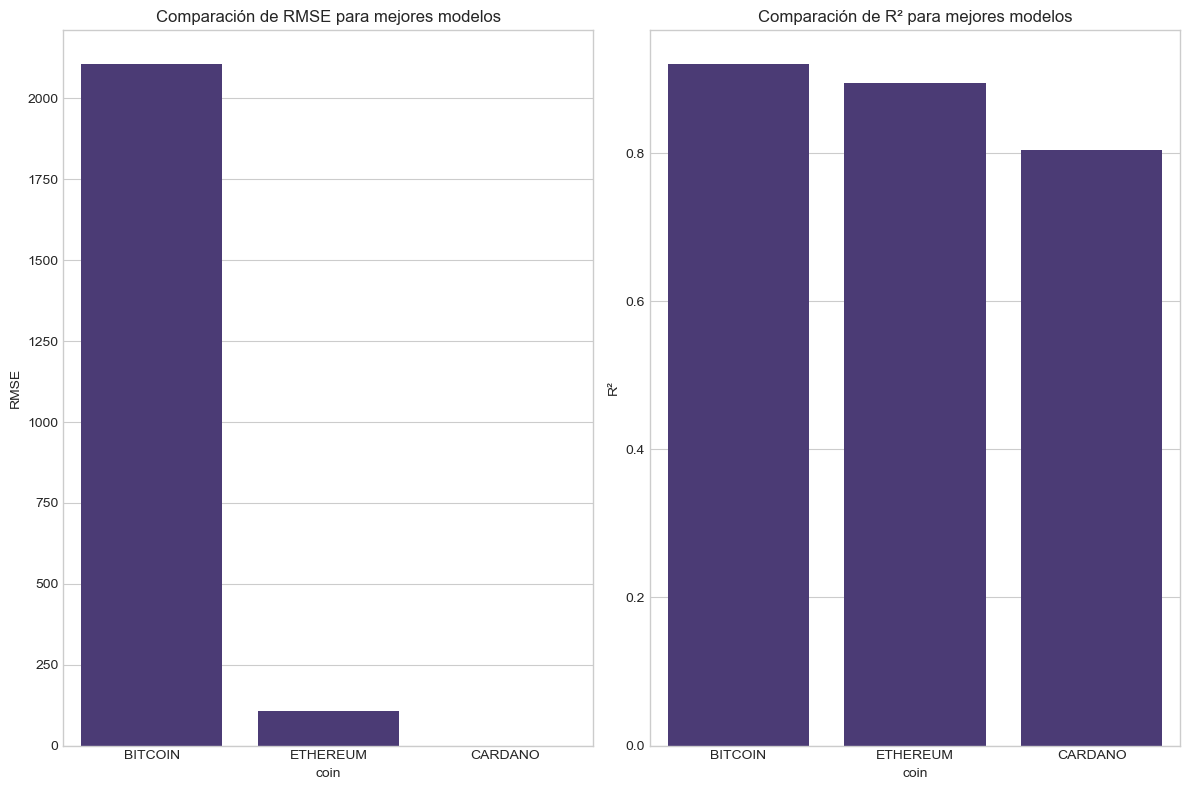


Conclusión:
BITCOIN: Mejor modelo = Ridge, RMSE = 2105.36, R² = 0.92
ETHEREUM: Mejor modelo = ElasticNet, RMSE = 107.04, R² = 0.89
CARDANO: Mejor modelo = Linear Regression, RMSE = 0.03, R² = 0.80

La criptomoneda con predicciones más precisas es: BITCOIN
Nota: Un valor más bajo de RMSE indica predicciones más precisas.
      Un valor de R² más cercano a 1 indica que el modelo explica mejor la variabilidad de los precios.


In [10]:
# Comparar rendimiento entre criptomonedas
plt.figure(figsize=(12, 8))
all_results = []

for coin, results in results_by_coin.items():
    best_row = results.sort_values('rmse').iloc[0]
    all_results.append({
        'coin': coin.upper(),
        'model': best_row['model'],
        'rmse': best_row['rmse'],
        'r2': best_row['r2']
    })

all_results_df = pd.DataFrame(all_results)

# Visualizar comparación de RMSE entre monedas
plt.subplot(1, 2, 1)
sns.barplot(x='coin', y='rmse', data=all_results_df)
plt.title('Comparación de RMSE para mejores modelos')
plt.ylabel('RMSE')

# Visualizar comparación de R² entre monedas
plt.subplot(1, 2, 2)
sns.barplot(x='coin', y='r2', data=all_results_df)
plt.title('Comparación de R² para mejores modelos')
plt.ylabel('R²')

plt.tight_layout()
plt.savefig('../data/crypto_model_comparison.png')
plt.show()

# Conclusión
print("\nConclusión:")
print("="*80)
for coin, results in results_by_coin.items():
    best_row = results.sort_values('rmse').iloc[0]
    print(f"{coin.upper()}: Mejor modelo = {best_row['model']}, RMSE = {best_row['rmse']:.2f}, R² = {best_row['r2']:.2f}")

best_coin = all_results_df.sort_values('r2', ascending=False)['coin'].iloc[0]
print(f"\nLa criptomoneda con predicciones más precisas es: {best_coin}")
print("="*80)
print("Nota: Un valor más bajo de RMSE indica predicciones más precisas.")
print("      Un valor de R² más cercano a 1 indica que el modelo explica mejor la variabilidad de los precios.")